In [2]:
# Playing around with normalising flows

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
layers = tf.keras.layers

In [4]:
tf.compat.v1.set_random_seed(0)
tf.compat.v1.VERSION

'2.0.0'

### Load the dataset which we want to mimick and transform into

In [5]:
# Settings for datatypes and models etc.
DTYPE=tf.float32
NP_DTYPE=np.float32
MODEL = 'NVP' # Choosing a Normalising Flow model from amongst NVP, MAF or IAF
TARGET_DENSITY = 'SIGGRAPH' # Will be loaded from the pickle file
USE_BATCHNORM = False

In [6]:
settings = {
    'SIGGRAPH': {
        'batch_size': 1500,
        'num_bijectors': 8,
        'train_iters': 5e4
    }
}

Presenting the distribution we want to learn from an initial Gaussian distribution


(-2, 2)

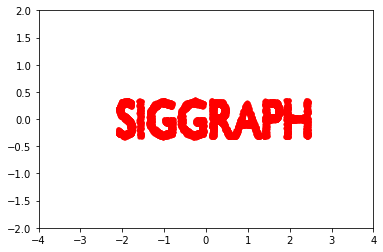

In [7]:
if TARGET_DENSITY == 'SIGGRAPH':
    import pickle
    with open('siggraph.pkl', 'rb') as f:
        X = np.array(pickle.load(f))
    X -= np.mean(X, axis=0) # centering
    x_lim, y_lim = [-4, 4], [-2, 2]
else:
    assert False, ("No other dataset intended for this use..")
print("Presenting the distribution we want to learn from an initial Gaussian distribution")
plt.scatter(X[:, 0], X[:, 1], s=10, color="red")
plt.xlim(x_lim)
plt.ylim(y_lim)

In [8]:
# From the above image, we subselect some components forming the dataset!
dataset = tf.data.Dataset.from_tensor_slices(X.astype(NP_DTYPE))
dataset = dataset.repeat() # repeats just once...
dataset = dataset.shuffle(buffer_size=X.shape[0])

# Damn, this stuff is really sexy! No more manual implementation of this!
dataset = dataset.prefetch(3 * settings[TARGET_DENSITY]['batch_size'])
dataset = dataset.batch(settings[TARGET_DENSITY]['batch_size'])

# Just checking if you can iterate over the dataset
data_iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
x_samples = data_iterator.get_next()

### Build the real-valued Non-volume-preserving normalising flow

In [15]:
# Super hacky implementation. 
# Next time, create a module which includes all variables
# Especially tricky for tf_probability_distribution functions!
nvp_variables = []

def net(x, out_size):
    """
        In principle, this is a network which 
        predicts the translation in the probability density.
        This is the affine coupling layer for the Real-NVP
    """
    fully_connected_1 = layers.Dense(512)
    fully_connected_2 = layers.Dense(512)
    fully_connected_3 = layers.Dense(out_size)
    
    nvp_variables.extend(
        [
            fully_connected_1.trainable_variables,
            fully_connected_2.trainable_variables,
            fully_connected_3.trainable_variables
        ]
    )
    
    x = fully_connected_1(x)
    x = fully_connected_2(x)
    x = fully_connected_3(x)
    
    return x

# TODO: Lol this will be full of bugs bcs tensorflow 2.0
class NVPCoupling(tfb.Bijector, tf.Module):
    """
        Non-Volume-Preserving coupling layer for 2D units.
        This is only a single layer and needs to 
        be stacked together multiple times! (does it...? yes! forloop)
    """
    
    def __init__(self, D, d, layer_id=0, validate_args=False, name="NVPCoupling"):
        """
            :param d: First d units are pass-through units (i.e. a mask is applied!)
        """
        # We inherit from the bijector class, because this function is supposed to be an invertible, 
        # affine transform on the "simple" probability distribution of choice.
        super(NVPCoupling, self).__init__(
            forward_min_event_ndims=1, 
            inverse_min_event_ndims=1,
            validate_args=validate_args, 
            name=name
        )
        self.D = D
        self.d = d
        self.id = layer_id
        # I think we can skip this random initial pass-through
        # tmp = tf.placeholder(dtype=DTYPE, shape=[1, self.d])
        # self.s(tmp)
        # self.t(tmp)
    
    def s(self, xd):
        # TODO: What is this shit?
        with tf.compat.v1.variable_scope("s{}".format(self.id, reuse=tf.compat.v1.AUTO_REUSE)):
            return net(xd, self.D - self.d)
        
    def t(self, xd):
        # TODO: What is the difference to the above function?
        with tf.compat.v1.variable_scope("t{}".format(self.id, reuse=tf.compat.v1.AUTO_REUSE)):
            return net(xd, self.D - self.d)
        
    def _forward(self, x):
        xd, xD = x[:, :self.d], x[:, self.d:]
        # Is this where the mask is applied?
        yD = xD * tf.exp(self.s(xd)) + self.t(xd)
        return tf.concat([xd, yD], axis=1)
    
    def _inverse(self, y):
        """
            The inverse of the forward is simple, as it is 
            just a linear function!
        """
        yd, yD = y[:, :self.d], y[:, self.d:]
        xD = (yD - self.t(yd)) * tf.exp(-self.s(yd))
        return tf.concat([yd, xD], axis=1)
    
    def _forward_log_det_jacobian(self, x):
        """
            Useful because a normalising flow is a 
            jacobian is volume-stretching
        """
        event_dims = 1
        xd = x[:, :self.d]
        return tf.reduce_sum(self.s(xd), axis=event_dims)
        
    

In [16]:
batchnorm_variables = []

# We have to write our own BatchNorm class, because there is none by 
# default in the batchnorm bijector logic...
class BatchNorm(tfb.Bijector, tf.Module):
    
    def __init__(self, eps=1e-5, decary=0.95, validate_args=False, name="batch_norm"):
        super(BatchNorm, self).__init__(
            event_ndims=1, validate_args = validate_args, name=name
        )
        self._vars_created = False
        self.eps = eps # Regualizing variable
        self.decay = decay
    
    def _create_vars(self, x):
        # Create as many batchnorm variables as there are features! (assuming matrix has this shape)
        n = x.get_shape().as_list()[1]
        self.beta = tf.Variable('{}/beta'.format(self.name), [1, n], dtype=DTYPE)
        self.gamma = tf.Variable('{}/gamma'.format(self.name), [1, n], dtype=DTYPE)
        self.train_m = tf.Variable('{}/mean'.format(self.name), [1, n], dtype=DTYPE, trainable=False)
        self.train_v = tf.Variable('{}/var'.format(self.name), [1, n], dtype=DTYPE, initializer=tf.ones_initializer, trainable=False)
        self._vars_created = True
        
        batchnorm_variables.extend(
            [
                self.beta.trainable_variables,
                self.gamma.trainable_variables,
                self.train_m.trainable_variables,
                self.train_v.trainable_variables
            ]
        )

    def _forward(self, u):
        if not self._vars_created:
            self._create_vars(u)
        return (u - self.beta) * tf.exp(-self.gamma) * tf.sqrt(self.train_v + self.eps) + self.train_m

    def _inverse(self, x):
        if not self._vars_created:
            self._create_vars(x)
        # Calculate the mean and std
        m, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        update_train_m = tf.assign_sub(
            self.train_m, self.decay * (self.train_m - m))
        update_train_v = tf.assign_sub(
            self.train_v, self.decay * (self.train_v - v))
        # Run the update only after the enclosing functions were called
        with tf.control_dependencies([update_train_m, update_train_v]):
            return (x - m) * 1./tf.sqrt(v + self.eps) * tf.exp(self.gamma) + self.beta
        
    def _inverse_log_det_jacobian(self, x):
        if not self._vars_created:
            self._create_vars(x)
        _, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        # The log determinant based on the linear transform
        abs_log_det_J_inv = tf.reduce_sum(
            self.gamma - 0.5 * tf.log(v + self.eps)
        )
        return abs_log_det_J_inv
    

### Now we construct the (normalising) flow

In [17]:
# Define and generate the base distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

In [18]:
num_bijectors = settings[TARGET_DENSITY]['num_bijectors']
bijectors = []

for i in range(num_bijectors):
    # Instantiate the NVP model 
    # D is the dimensionality of the space, 
    # d is the number of dimensions that we act on!
    bijectors.append(
        NVPCoupling(D=2, d=1, layer_id=i)
    )
    
    if USE_BATCHNORM and I % 2 == 0:
        bijectors.append(BatchNorm(name='batch_norm{}'.format(i)))
    
    # Appending batchnorm if this is something we want..
    # Dafuq is this permutation for.....???? 
    # In the post he also said this is required for this to work..
    bijectors.append(tfb.Permute(permutation=[1, 0]))

flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
    
print("Flow bijectors are: ", flow_bijector)

Flow bijectors are:  <tensorflow_probability.python.bijectors.chain.Chain object at 0x12a3482b0>


In [19]:
# The output distribution is as follows
dist = tfp.distributions.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector
)

### Now we go into visualizing everything that we have built

In [20]:
x = base_dist.sample(8000)
samples = [x]
names = [base_dist.name]
# Why do we apply this in reverse...?
# Because we reverse them before to be able to apply these.. 
# (i.e. we go from "complex" distribution, to "simple" distribution [inverse])
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)    
    
# We have repeated Gaussian transforms, 
# so there should be no change in the type of distribution

print("Working...")
print("All names are")
for name in names:
    print(name)

Working...
All names are
MultivariateNormalDiag
NVPCoupling
permute
NVPCoupling
permute
NVPCoupling
permute
NVPCoupling
permute
NVPCoupling
permute
NVPCoupling
permute
NVPCoupling
permute
NVPCoupling


In [21]:
# Initialize all global variables... 
# Probably not needed anymore due to eager execution

In [22]:
# Get some samples from the base distribution

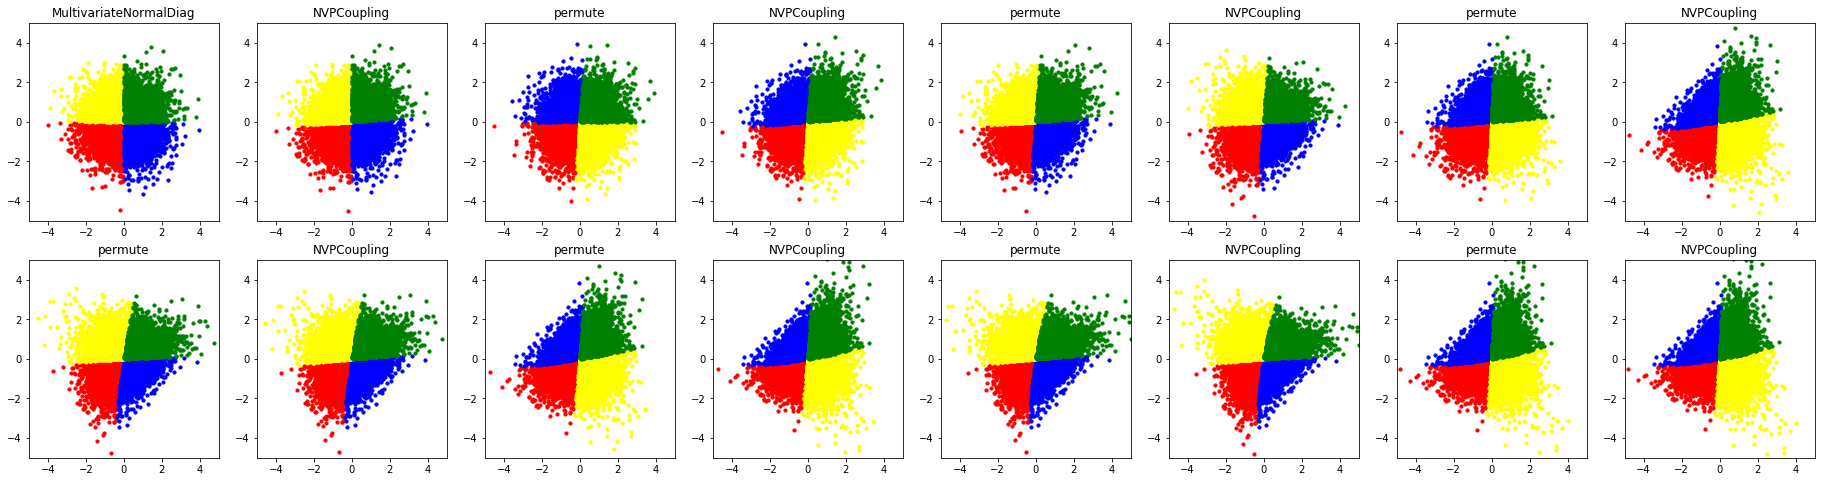

In [23]:
results = samples
# print("Results are: ", results)
# Plot the samples into the respective subplots...
X0 = results[0]

# Numpy advanced indexing is not supported right now, 
# so I need to cast it back and forth to numpy

X0 = np.asarray(X0)
rows = 2
cols = len(results) // 2

fig, arr = plt.subplots(2, cols, figsize=(4 * (cols), 4*rows))
i = 0
for r in range(rows):
    for c in range(cols):
        X1 = results[i]
        X1 = np.asarray(X1)
        # Color the four pie-pieces (by axis...)
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
        
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='yellow')
        
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
        arr[r, c].set_xlim([-5, 5])
        arr[r, c].set_ylim([-5, 5])
        arr[r, c].set_title(names[i])
        i += 1
    
# Not quite staying as normal distributions, but close enough. 
# There are some significant transformations at some point.

### Optimizing the flow

In [27]:
NUM_STEPS = int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
np_losses = []

# Expand all variables...
print(nvp_variables)
print(batchnorm_variables)
print(len(nvp_variables))
print(len(batchnorm_variables))

# dist.log_prob(x_samples)

for i in range(NUM_STEPS):
    loss = -tf.reduce_mean(dist.log_prob(x_samples))
    # print("Collecting all trainable parameters...", flow_bijector.variables)
    optimizer = tf.optimizers.Adam(1e-4)
    if i % 5 == 0:
        global_step.append(i)
        np_losses.append(loss)
    if i % int(5) == 0:
        print(i, loss)
        
start = 0
plt.plot(np_losses[start:])

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[]
48
0
0 tf.Tensor(2.9069176, shape=(), dtype=float32)
5 tf.Tensor(2.8978093, shape=(), dtype=float32)


KeyboardInterrupt: 

### Visualize everything after training again

In [ ]:
results = samples
# print("Results are: ", results)
# Plot the samples into the respective subplots...
X0 = results[0]

# Numpy advanced indexing is not supported right now, 
# so I need to cast it back and forth to numpy

X0 = np.asarray(X0)
rows = 2
cols = len(results) // 2

fig, arr = plt.subplots(2, cols, figsize=(4 * (cols), 4*rows))
i = 0
for r in range(rows):
    for c in range(cols):
        X1 = results[i]
        X1 = np.asarray(X1)
        # Color the four pie-pieces (by axis...)
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
        
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='yellow')
        
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
        arr[r, c].set_xlim([-5, 5])
        arr[r, c].set_ylim([-5, 5])
        arr[r, c].set_title(names[i])
        i += 1
    
# Not quite staying as normal distributions, but close enough. 
# There are some significant transformations at some point.